# New York Taxi Fare Prediction
Score Metric: Root Mean Squared Error (RMSE)

Objective: RMSE < 4

## Import required libraaries

In [1]:
import pandas as pd
import numpy as np
#import pandas_profiling
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Geod
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)

TRAIN_PATH = 'new-york-city-taxi-fare-prediction/train.csv'
TEST_PATH = 'new-york-city-taxi-fare-prediction/test.csv'

## Reading Data and performing cleaning of the data for further pre processing

In [2]:
df_tr = pd.read_csv(TRAIN_PATH, nrows=100000)
#profile = pandas_profiling.ProfileReport(df_temp, title="Profile Report", minimal=True, progress_bar=False)
#profile.to_notebook_iframe()

In [3]:
df_tr[df_tr['pickup_longitude']>0].head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2147,2013-05-24 14:54:00.00000079,5.0000,2013-05-24 14:54:00 UTC,40.7516,-73.9870,40.7589,-73.9784,2
3827,2013-06-20 04:28:00.0000001,11.0000,2013-06-20 04:28:00 UTC,40.7198,-73.9885,40.7233,-73.9394,1
4783,2013-05-22 06:28:00.0000004,6.5000,2013-05-22 06:28:00 UTC,40.7483,-73.9918,40.7404,-73.9790,1
6705,2013-05-22 15:33:00.000000175,13.0000,2013-05-22 15:33:00 UTC,40.7661,-73.9833,40.7574,-73.9780,2
7525,2013-05-22 10:54:00.000000140,13.0000,2013-05-22 10:54:00 UTC,40.7605,-73.9730,40.7404,-73.9944,1


1. Extracting data from the Date attribute
2.  On checking for any data being incorectly entered we find that some values of latitudes and longitudes might have been entered in the reverse manner, hence we reverse these values
3. Ignore the key column as  it is just an identifier  for the provided data and does not affect the training.
4. Removing rows with negative fare_amount values and  setting an upper bound to the attribute.
5. Removing rows without latitude and longitude input and setting an upper bound. The geograaphical boundary of New York is around latitude : 40 and longitude: -73
6. Removing rows with ZERO passenger_count and setting an upper bound for the  attribute

In [4]:
def data_clean(df):
    #Extracting date 
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 15)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    #reversing incorrectly assigned longitude and latitude values
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    
    #remove data points outside appropriate ranges
    criteria = (
    " 0 < fare_amount <= 500"
    " and 0 < passenger_count <= 6 "
    " and -75 <= pickup_longitude <= -72 "
    " and -75 <= dropoff_longitude <= -72 "
    " and 40 <= pickup_latitude <= 42 "
    " and 40 <= dropoff_latitude <= 42 "
    )
    #dropping the data valus not satisfying the criteria  in the query, resetting the index of the data and dropping 
    #the new columns formed above for data cleaning
    df = (df
          .dropna()
          .query(criteria)
          .reset_index()
          .drop(columns=['rev', 'index'])          
         )
    return df

def load_df(nrows=None, features=None):
    #load dataframe in chunks if the number of rows requested is high (currently only using 1 million rows for faster training)
    #columns to be included while training
    cols = [
        'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
    ]
    df_as_list = []
    for df_chunk in pd.read_csv(TRAIN_PATH, usecols=cols, nrows=nrows, chunksize=5000000):
        df_chunk = data_clean(df_chunk) 
        if features == 'explore':
            df_chunk = exploration_features(df_chunk)
        elif features == 'model':
            df_chunk = modelling_features(df_chunk)
        else:
            df_chunk = df_chunk.drop(columns='pickup_datetime')
        df_as_list.append(df_chunk)
    df = pd.concat(df_as_list)
    return df

In [5]:
# Loading Data
train = load_df(10000000)
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9758850.0000,9758850.0000,9758850.0000,9758850.0000,9758850.0000,9758850.0000
mean,11.3297,-73.9752,40.7510,-73.9743,40.7514,1.6908
std,9.6978,0.0391,0.0300,0.0383,0.0332,1.3066
min,0.0100,-74.9899,40.0000,-74.9983,40.0000,1.0000
25%,6.0000,-73.9923,40.7365,-73.9916,40.7356,1.0000
50%,8.5000,-73.9821,40.7533,-73.9806,40.7539,1.0000
75%,12.5000,-73.9683,40.7675,-73.9654,40.7684,2.0000
max,500.0000,-72.0632,41.9839,-72.0670,41.9981,6.0000


##Creating a baseline model for training a model on our unprocesssed data
1. Splitting data to train an dvalidation sets
2. Models selected: Linear Regression, k-NN, Random Forest, Gradient Boosting, XGBoost, LightGBM
3. Performing training for 1M rows of datapoints

In [33]:
def get_split_sets(train):
    x = train.drop(columns=['fare_amount'])
    y = train['fare_amount'].values
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
    return x_train, x_val, y_train, y_val


def lin_model(x_train, x_val, y_train, y_val):
    model = LinearRegression()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred


def knn_model(x_train, x_val, y_train, y_val, neighbors):
    min_rmse = 1000
    for n in neighbors:
        knn = KNeighborsRegressor(n_neighbors=n)
        knn.fit(x_train, y_train)
        pred = knn.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        if rmse < min_rmse:
            min_rmse = rmse
            model = knn
            best_pred = pred
        print('Neighbours', n, 'RMSE', rmse)
    return model, min_rmse, best_pred

def rf_model(x_train, x_val, y_train, y_val):
    model = RandomForestRegressor(min_impurity_decrease= 0, n_estimators=50,
                                    max_depth=15, min_samples_leaf=30)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred

def gbm_model(x_train, x_val, y_train, y_val):
    model = GradientBoostingRegressor(n_estimators=50,learning_rate=1, max_features=3,
                                        max_depth=15,min_samples_leaf=60, random_state=0)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred

def XGBoost_model(x_train, x_val, y_train, y_val):
    model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=0.1, 
                               subsample=0.8, colsample_bytree=0.8)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred

def lgbm_model(params,x_train, x_val, y_train, y_val):
    lgbm_train = lgbm.Dataset(x_train, y_train, silent=True)
    lgbm_val = lgbm.Dataset(x_val, y_val, silent=True)
    model = lgbm.train(params=params, train_set=lgbm_train, valid_sets=lgbm_val, verbose_eval=100)
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred
train1= load_df(1000000)
x_train1, x_val1, y_train1, y_val1= get_split_sets(train1)
test1 = pd.read_csv(TEST_PATH)
x_test1 = test1.drop(columns=['key'])

In [7]:
lin_init_model, lin_init_rmse, lin_init_pred = lin_model(x_train, x_val, y_train, y_val)


In [8]:
k_choices = [10,20,30,40,50,60]
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude',
            'dropoff_latitude']
knn_init, knn_init_rmse, knn_init_pred = knn_model(x_train[knn_cols], x_val[knn_cols],
                                                    y_train, y_val, k_choices)

Neighbours 10 RMSE 4.072911217703026
Neighbours 20 RMSE 4.041029323185092
Neighbours 30 RMSE 4.020859356298846
Neighbours 40 RMSE 4.035039700520045
Neighbours 50 RMSE 4.054464509243801
Neighbours 60 RMSE 4.064073815507545


In [9]:
gbm_init, gbm_init_rmse, gbm_init_pred = gbm_model(x_train[knn_cols], x_val[knn_cols],
                                                    y_train, y_val)

In [34]:
rf_init, rf_init_rmse, rf_init_pred = rf_model(x_train1[knn_cols], x_val1[knn_cols],
                                                    y_train1, y_val1)

In [35]:
Xgbm_init, Xgbm_init_rmse, Xgbm_init_pred = XGBoost_model(x_train1[knn_cols], x_val1[knn_cols],
                                                    y_train1, y_val1)

In [12]:
lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 400,
    'learning_rate': 0.1,
    'max_bin': 3000,
    'num_rounds': 5000,
    'early_stopping_rounds': 100,
    'metric' : 'rmse'
}
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
lgbm_init_model, lgbm_init_rmse, lgbm_init_pred = lgbm_model(lgbm_params, x_train,
                                                             x_val, y_train, y_val)

lgbm_init_model1, lgbm_init_rmse1, lgbm_init_pred1 = lgbm_model(params, x_train,
                                                             x_val, y_train, y_val)
                                                                                                                          

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12007
[LightGBM] [Info] Number of data points in the train set: 878552, number of used features: 5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 4.02757
Early stopping, best iteration is:
[87]	valid_0's rmse: 4.02609
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20007
[LightGBM] [Info] Number of data points in the train set: 878552, number of used features: 5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Cu

In [36]:
print('Linear Regression RMSE', lin_init_rmse)
print('KNN RMSE', knn_init_rmse)
print('RF RMSE', rf_init_rmse)
print('GBM RMSE', gbm_init_rmse)
print('XGBM RMSE', Xgbm_init_rmse)
print('LightGBM RMSE', lgbm_init_rmse)
print('LightGBM RMSE1', lgbm_init_rmse1)

Linear Regression RMSE 8.302046575702484
KNN RMSE 4.020859356298846
RF RMSE 4.481784631207605
GBM RMSE 4.2819870555284485
XGBM RMSE 4.204629236530396
LightGBM RMSE 4.02609480074296
LightGBM RMSE1 4.172015669987417


Linear Regression RMSE 8.302046575702484

KNN RMSE 4.020859356298846

Rf RMSE 4.7329242373031155

GBM RMSE 4.732884671913976

XGBM RMSE 4.732871380541663
LightGBM RMSE 4.02609480074296

In [44]:
init_preds_ave = 0
for i in [ lin_init_pred, knn_init_pred, rf_init_pred, gbm_init_pred,Xgbm_init_pred, lgbm_init_pred]:
    for j in [ rf_init_pred,Xgbm_init_pred, lgbm_init_pred]:
        init_preds_ave = (i+j)/2
        #print(i)
    rmse = np.sqrt(mean_squared_error(y_val1, init_preds_ave))
    print( '\n','Combined RMSE: ', rmse)


 Combined RMSE:  5.429403437413215

 Combined RMSE:  3.9583502088886324

 Combined RMSE:  4.126709273449065

 Combined RMSE:  4.058390362587789

 Combined RMSE:  4.041632512625609

 Combined RMSE:  4.02609480074296


# Exploratory Data Analysis (EDA), Pre-Processing, Data Extraction  

In [15]:
def dist_driven(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return dist
def driving_dir(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return az12

def EDA_feats(df):
    rows = len(df)
    #arguments to the distance function
    nyc_long, nyc_lat = [-74.001541]*rows, [40.724944]*rows    
    jfk_long, jfk_lat = [-73.785937]*rows, [40.645494]*rows
    lga_long, lga_lat = [-73.872067]*rows, [40.774071]*rows
    nla_long, nla_lat = [-74.177721]*rows, [40.690764]*rows
    chp_long, chp_lat = [-73.137393]*rows, [41.366138]*rows
    exp_long, exp_lat = [-74.0375]*rows, [40.736]*rows
    pickup_long = df.pickup_longitude.tolist()
    pickup_lat = df.pickup_latitude.tolist()
    dropoff_long = df.dropoff_longitude.tolist()
    dropoff_lat = df.dropoff_latitude.tolist()
    
    #EDA
    df = df.assign(
        #time features
        year=df.pickup_datetime.dt.year,
        dayofyear=df.pickup_datetime.dt.dayofyear,
        weekday=df.pickup_datetime.dt.dayofweek,
        time=(df.pickup_datetime.dt.hour+df.pickup_datetime.dt.minute/5),
        
        #distance between pickup and dropoff, and bearing from pickup to dropoff
        distance=dist_driven(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        direction=dist_driven(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        
        #distance from locations
        pickup_dist_nyc=pd.Series(dist_driven(pickup_long, pickup_lat, nyc_long, nyc_lat)),
        dropoff_dist_nyc=pd.Series(dist_driven(dropoff_long, dropoff_lat, nyc_long, nyc_lat)),
        pickup_dist_jfk=pd.Series(dist_driven(pickup_long, pickup_lat, jfk_long, jfk_lat)),
        dropoff_dist_jfk=pd.Series(dist_driven(dropoff_long, dropoff_lat, jfk_long, jfk_lat)),
        pickup_dist_lga=pd.Series(dist_driven(pickup_long, pickup_lat, lga_long, lga_lat)),
        dropoff_dist_lga=pd.Series(dist_driven(dropoff_long, dropoff_lat, lga_long, lga_lat)),
        pickup_dist_nla=pd.Series(dist_driven(pickup_long, pickup_lat, nla_long, nla_lat)),
        dropoff_dist_nla=pd.Series(dist_driven(dropoff_long, dropoff_lat, nla_long, nla_lat)),
        pickup_dist_chp=pd.Series(dist_driven(pickup_long, pickup_lat, chp_long, chp_lat)),
        dropoff_dist_chp=pd.Series(dist_driven(dropoff_long, dropoff_lat, chp_long, chp_lat)),
        pickup_dist_exp=pd.Series(dist_driven(pickup_long, pickup_lat, exp_long, exp_lat)),
        dropoff_dist_exp=pd.Series(dist_driven(dropoff_long, dropoff_lat, exp_long, exp_lat))
    )
    return df


def exploration_features(df):
    """Features created for EDA"""
    df = EDA_feats(df)
    df = (
        df
        .assign(
            hour=df.pickup_datetime.dt.hour,
            close_to_airport='No',
            fare_per_km=df.fare_amount*1000/df.distance,
            direction_bucket = pd.cut(df.direction, np.linspace(-180, 180, 37)),

            #small location buckets
            pickup_long_bucket=pd.cut(df.pickup_longitude, bins=2550, labels=False),
            pickup_lat_bucket=pd.cut(df.pickup_latitude, bins=2200, labels=False),
            dropoff_long_bucket=pd.cut(df.dropoff_longitude, bins=2550, labels=False),
            dropoff_lat_bucket=pd.cut(df.dropoff_latitude, bins=2200, labels=False),

            #large location buckets
            pickup_long_bucket_big=pd.cut(df.pickup_longitude, bins=255, labels=False),
            pickup_lat_bucket_big=pd.cut(df.pickup_latitude, bins=220, labels=False),
            dropoff_long_bucket_big=pd.cut(df.dropoff_longitude, bins=255, labels=False),
            dropoff_lat_bucket_big=pd.cut(df.dropoff_latitude, bins=220, labels=False)
        )
        .drop(columns='pickup_datetime')
        .query("0 < distance")
    )
    df.loc[((df['pickup_dist_jfk']<1500) | (df['dropoff_dist_jfk']<1500)), 'close_to_airport'] = 'JFK'
    df.loc[((df['pickup_dist_lga']<1500) | (df['dropoff_dist_lga']<1500)), 'close_to_airport'] = 'LaGuardia'
    df.loc[((df['pickup_dist_nla']<1500) | (df['dropoff_dist_nla']<1500)), 'close_to_airport'] = 'Newark'  
    return df

## Checking relations of target variable with other attributes.
1. Passenger Count
2. Drivrn distance for a trip
3. 

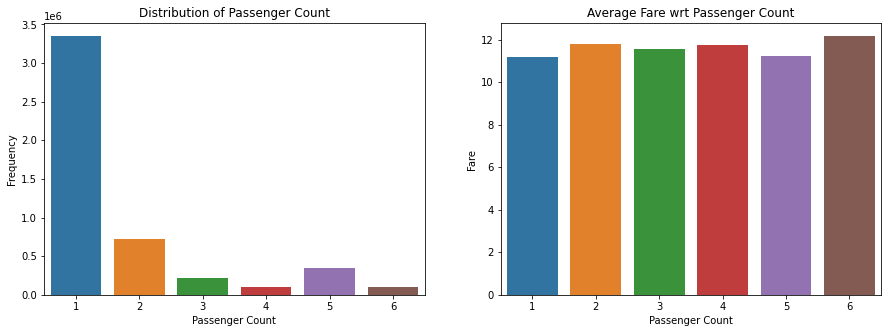

In [16]:
train = load_df(5000000, features='explore')
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(train.passenger_count, ax=ax[0])
ax[0].set_xlabel('Passenger Count')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Passenger Count')
sns.barplot(train.passenger_count, train.fare_amount, ax=ax[1], ci=None)
ax[1].set_xlabel('Passenger Count')
ax[1].set_ylabel('Fare')
ax[1].set_title('Average Fare wrt Passenger Count')
fig.show()


Text(0, 0.5, 'Fare ($)')

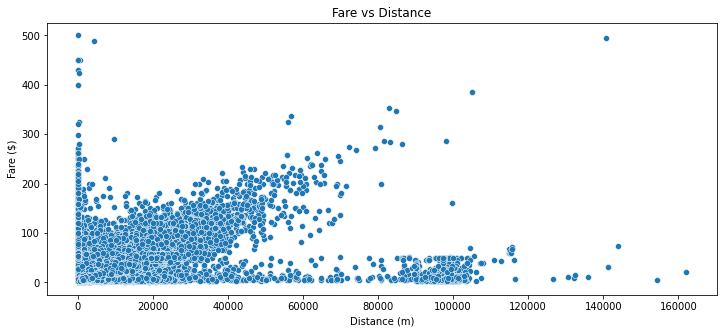

In [17]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x='distance', y='fare_amount', data=train).set_title('Fare vs Distance')
plt.xlabel('Distance (m)')
plt.ylabel('Fare ($)')

In [18]:
#Trips over 75km
long_trips = train[train.distance>75000].fare_amount.count()
print(long_trips, 'trips over 75km.')

788 trips over 75km.


Average fare for distance over 75km: 21.086713197969544
Average fare for distance 50-75km: 113.41310975609755


Text(0.5, 0, 'Distance')

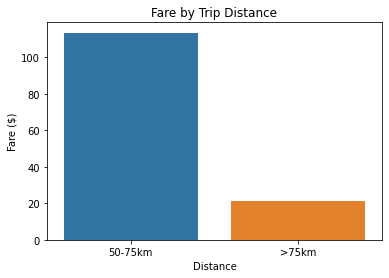

In [19]:
#Avg fare of over 75km with shorter distance 50-75km'
print('Average fare for distance over 75km:', train[train.distance>75000].fare_amount.mean())
print('Average fare for distance 50-75km:', train.query('50000 < distance < 75000').fare_amount.mean())
sns.barplot(['50-75km', '>75km'],[train.query('50000 < distance < 75000').fare_amount.mean(),train[train.distance>75000].fare_amount.mean()])
plt.title('Fare by Trip Distance')
plt.ylabel('Fare ($)')
plt.xlabel('Distance')

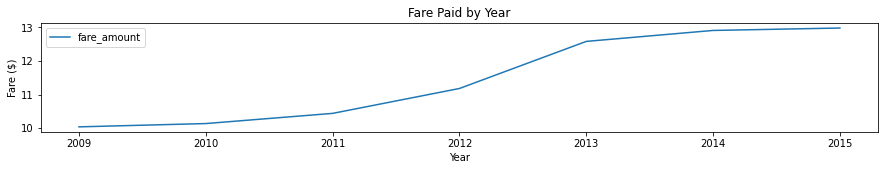

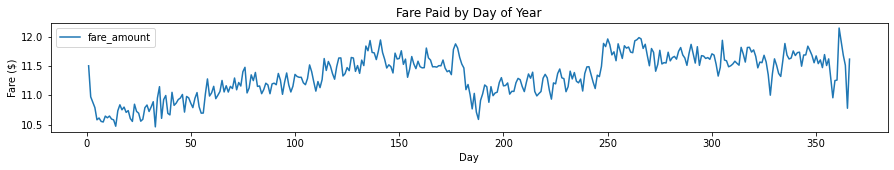

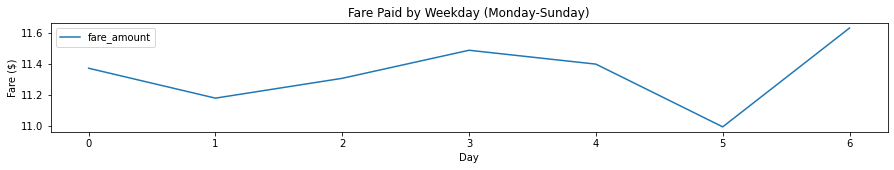

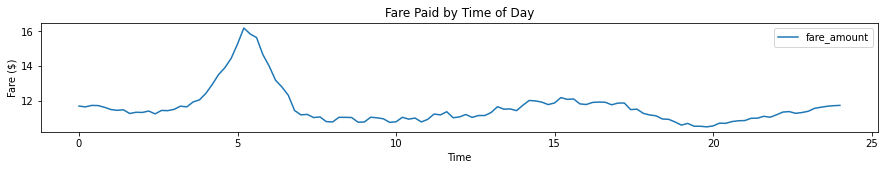

In [20]:
train.pivot_table('fare_amount', index='year').plot(figsize=(15,2))
plt.title('Fare Paid by Year')
plt.ylabel('Fare ($)')
plt.xlabel('Year')
train.pivot_table('fare_amount', index='dayofyear').plot(figsize=(15,2))
plt.title('Fare Paid by Day of Year')
plt.ylabel('Fare ($)')
plt.xlabel('Day')
train.pivot_table('fare_amount', index='weekday').plot(figsize=(15,2))
plt.title('Fare Paid by Weekday (Monday-Sunday)')
plt.ylabel('Fare ($)')
plt.xlabel('Day')
train.pivot_table('fare_amount', index='time').plot(figsize=(15,2))
plt.ylabel('Fare ($)')
plt.xlabel('Time')
plt.title('Fare Paid by Time of Day')
plt.show()

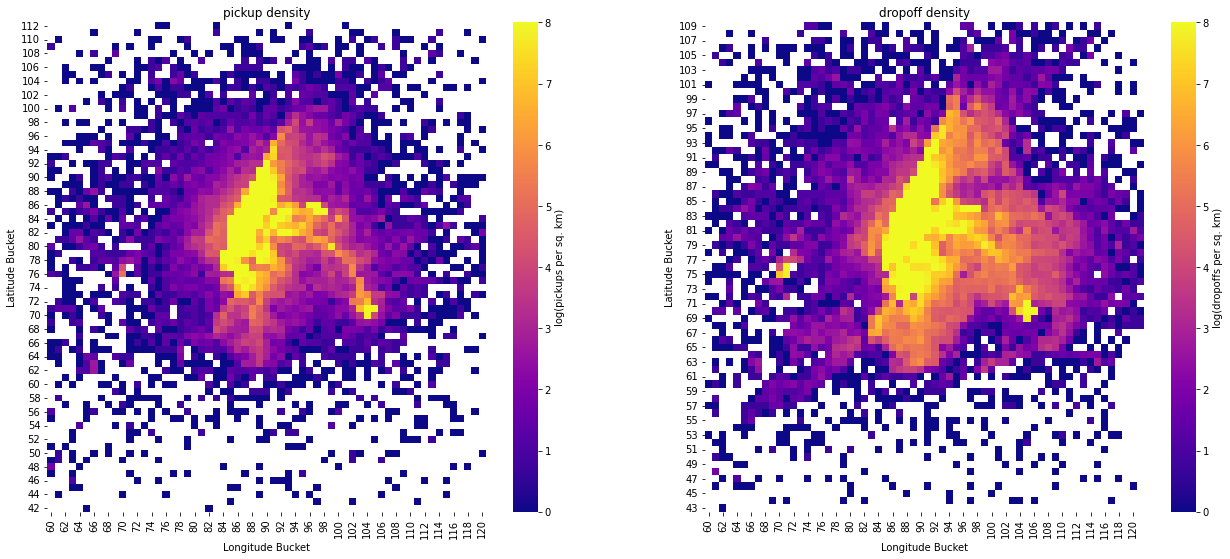

In [21]:
def density_heatmap(direction):
    df = np.log(
        train
        .query(f'-74.3 < {direction}_longitude < -73.6')
        .query(f'40.4 < {direction}_latitude < 41')
        .groupby([f'{direction}_long_bucket_big',f'{direction}_lat_bucket_big'])
        .distance
        .count()
        .unstack(level=0)
        .iloc[::-1]
    )
    sns.heatmap(df, cmap="plasma", vmax=8, cbar_kws={'label':f'log({direction}s per sq. km)'}, ax=ax)
    plt.title(f'{direction} density')
    plt.ylabel('Latitude Bucket')
    plt.xlabel('Longitude Bucket')
    
fig = plt.figure(figsize=(10, 9))
fig.subplots_adjust(wspace=0.2, right=1.8)
ax = fig.add_subplot(1, 2, 1)
density_heatmap('pickup')
ax = fig.add_subplot(1, 2, 2)
density_heatmap('dropoff')
plt.show()

Text(0, 0.5, 'Fare ($)')

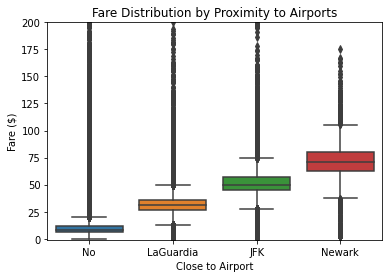

In [22]:
sns.boxplot(x=train['close_to_airport'], y=train['fare_amount'])
plt.title('Fare Distribution by Proximity to Airports')
plt.ylim(-1,200)
plt.xlabel('Close to Airport')
plt.ylabel('Fare ($)')

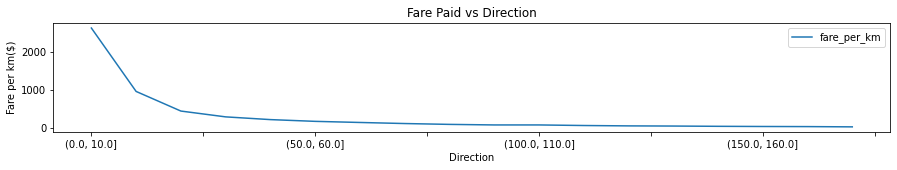

In [23]:
train.query('distance > 5').pivot_table('fare_per_km', index='direction_bucket', aggfunc='mean').plot(figsize=(15,2))
plt.ylabel('Fare per km($)')
plt.xlabel('Direction')
plt.title('Fare Paid vs Direction')
plt.show()

In [24]:
def modelling_features(df):
    df = EDA_feats(df)
    # using alternative representation of cyclic features
    df = df.assign(
        sin_time=np.sin(2*np.pi*df['time']/24),
        cos_time=np.cos(2*np.pi*df['time']/24),
        sin_direction=np.sin(2*np.pi*df['direction']/360),
        cos_direction=np.cos(2*np.pi*df['direction']/360),
        sin_dayofyear=np.sin(2*np.pi*df['dayofyear']/365),
        cos_dayofyear=np.cos(2*np.pi*df['dayofyear']/365),
        sin_weekday=np.sin(2*np.pi*df['weekday']/6),
        cos_weekday=np.cos(2*np.pi*df['weekday']/6),
        direction_bucket=pd.cut(df['direction'], bins=37, labels=False)
        ).drop(columns=['pickup_datetime', 'time', 'direction', 'weekday', 'dayofyear'])
    return df

In [25]:
train = load_df(10000000, features='model')

test1['pickup_datetime'] = test1['pickup_datetime'].str.slice(0, 15)
test1['pickup_datetime'] = pd.to_datetime(test1['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
test = modelling_features(test1)

train = (train
    .query(f'{test.pickup_longitude.min()-0.1} <= pickup_longitude <= {test.pickup_longitude.max()+0.1}')
    .query(f'{test.pickup_latitude.min()-0.1} <= pickup_latitude <= {test.pickup_latitude.max()+0.1}')
    .query(f'{test.dropoff_longitude.min()-0.1} <= dropoff_longitude <= {test.dropoff_longitude.max()+0.1}')
    .query(f'{test.dropoff_latitude.min()-0.1} <= dropoff_latitude <= {test.dropoff_latitude.max()+0.1}')
)

x_train, x_val, y_train, y_val = get_split_sets(train)

x_train['fare_per_km'] = y_train*1000/(x_train.distance+5)
fares_by_direction = x_train.query('5 < distance').groupby('direction_bucket')['fare_per_km'].mean()

#x_train['adj_dist'] = [fares_by_direction[i] for i in x_train.direction_bucket]*x_train.distance/fares_by_direction.max()
#x_val['adj_dist'] = [fares_by_direction[i] for i in x_val.direction_bucket]*x_val.distance/fares_by_direction.max()
#test['adj_dist'] = [fares_by_direction[i] for i in test.direction_bucket]*test.distance/fares_by_direction.max()



In [27]:
x_train = x_train.drop(columns=['fare_per_km', 'direction_bucket'])
x_val = x_val.drop(columns=['direction_bucket'])
x_test = test.drop(columns=['key', 'direction_bucket'])

In [28]:
lin_final_model2, lin_final_rmse2, lin_final_pred2 = lin_model(x_train, x_val, y_train, y_val)


In [29]:
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
k_choices = [18,24,30,40]
knn_final_model2, knn_final_rmse2, knn_final_pred2 = knn_model(x_train[knn_cols], x_val[knn_cols], y_train, y_val, k_choices)

Neighbours 18 RMSE 4.009314191026687
Neighbours 24 RMSE 3.9960945894118023
Neighbours 30 RMSE 3.9884537481391704
Neighbours 40 RMSE 3.9862082402349923


In [30]:
lgbm_params2 = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'reg_sqrt': True,
    'learning_rate': 0.03,
    'num_leaves': 1200,
    'max_depth': -1,
    'max_bin': 5000,
    'num_rounds': 5000,
    'early_stopping_round': 50,
    'metric': 'rmse'
}
lgbm_final_model2, lgbm_final_rmse2, lgbm_final_pred2 = lgbm_model(lgbm_params, x_train, x_val, y_train, y_val)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.143523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57858
[LightGBM] [Info] Number of data points in the train set: 8781381, number of used features: 27
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.45653
[200]	valid_0's rmse: 3.42873
[300]	valid_0's rmse: 3.41839
[400]	valid_0's rmse: 3.41464
[500]	valid_0's rmse: 3.41155
[600]	valid_0's rmse: 3.4093
[700]	valid_0's rmse: 3.40864
[800]	valid_0's rmse: 3.40936
Early stopping, best iteration is:
[743]	valid_0's rmse: 3.40805


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

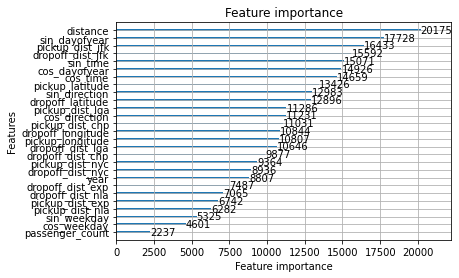

In [31]:
lgbm.plot_importance(lgbm_final_model2)  

In [45]:
rf_final_model2, rf_final_rmse2, rf_final_pred2 = rf_model(x_train, x_val, y_train, y_val)

KeyboardInterrupt: 

In [ ]:
gb_final_model2, gb_final_rmse2, gb_final_pred2 = gbm_model(x_train, x_val, y_train, y_val)

In [ ]:
XGBoost_final_model2, XGBoost_final_rmse2, XGBoost_final_pred2 = XGBoost_model(x_train, x_val, y_train, y_val)

In [ ]:
print('Linear Regression RMSE', lin_final_rmse2)
print('KNN RMSE', knn_final_rmse2)
print('LightGBM RMSE', lgbm_final_rmse2)
#print('Random Forest RMSE', rf_final_rmse2)
#print('Gradient Boosting RMSE', gb_final_rmse2)
#print('XGBoost RMSE', XGBoost_final_rmse2)

Linear Regression RMSE 4.948257171609363
KNN RMSE 3.9862082402349923
LightGBM RMSE 3.4080536693207515


In [46]:
d = {}
for a in np.linspace(0,1,101):
    final_preds_ave = (lgbm_final_pred2*(1-a) + knn_final_pred2 * a)
    rmse = np.sqrt(mean_squared_error(y_val, final_preds_ave))
    d[a] = rmse
alpha = min(d, key=d.get)
print('Best weight to give KNN: ', alpha)   

Best weight to give KNN:  0.08


In [47]:
lgbm_test_pred = lgbm_final_model2.predict(x_test, num_iteration=lgbm_final_model2.best_iteration)
knn_test_pred = knn_final_model2.predict(x_test[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
submission_pred = (lgbm_test_pred*(1-alpha) + knn_test_pred * alpha)
submission = pd.DataFrame({'key': test.key, 'fare_amount': submission_pred})
submission.to_csv('sub1.csv', index=False)

In [49]:
lgbm_test_pred = lgbm_final_model2.predict(x_test, num_iteration=lgbm_final_model2.best_iteration)
submission = pd.DataFrame({'key': test.key, 'fare_amount': lgbm_test_pred})
submission.to_csv('sub2.csv', index=False)